In [1]:
import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm

data_name = "HI-II-14" #HI-II-14, Digg
experiment_type = "ND"
step_ratio = 0.01


In [2]:
def make_dir(path):
    try: os.makedirs(path)
    except: return -1

In [7]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
G = nx.read_gml(network_file_path, destringizer=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

_g_num_nodes = G.number_of_nodes()
_CN_denom = (((_g_num_nodes * (_g_num_nodes - 1))) /2) #total possible pariwise connectivity
k = int(_g_num_nodes * step_ratio)
print("Node removals per iteration: ", k)
print("Total possible pairwise connectivity", int(_CN_denom))



def calc_graph_connectivity(G, experiment_type=experiment_type):
    if(G.number_of_nodes() in [0, 1]): return 0
    if(experiment_type=="CN"):
        pairwise_connectivity = 0
        for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
        pc = pairwise_connectivity / _CN_denom
        return pc
    else:
        maxCC = len(max(nx.connected_components(G), key=len))
        #print(maxCC , _g_num_nodes)
        return maxCC / _g_num_nodes


Number of nodes in the graph: 4165
Number of edges in the graph: 13087
Node removals per iteration:  41
Total possible pairwise connectivity 8671530


In [8]:
# high degree adaptive
def AdaptiveBaselines(G, k=k,approach='HDA', write=False):
    connectivity_scores_list = []
    connectivity_scores_list.append(calc_graph_connectivity(G))

    print("{} for k: {}".format(approach, k))

    while(True):
        print("- ", end="")
        if(approach=='HDA'):
            node_scores = dict(G.degree)
        node_scores_sorted = list(sorted(node_scores.items(), key=lambda item: item[1], reverse=True))
        isTerminal = k > len(node_scores_sorted)

        num_removals = int(min(k, len(node_scores_sorted)))
        node_score_pairs = node_scores_sorted[0:num_removals]
        node_removals = [i[0] for i in node_score_pairs]

        G.remove_nodes_from(node_removals)

        connectivity_scores_list.append(calc_graph_connectivity(G))

        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])
        print("\t-Finished export")

    return connectivity_scores_list

In [53]:
def calc_score_from_nodes_file(G, node_files, export_path, k=k, write=False):
    connectivity_scores_list = []
    connectivity_scores_list.append(calc_graph_connectivity(G))

    f = open(node_files,'r')
    node_removals = []
    for node in f:
        node_removals.append(int(node))
    print(len(node_removals))
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]
        #print(curr_node_removals)
        #print("=======")
        G.remove_nodes_from(curr_node_removals)

        connectivity_scores_list.append(calc_graph_connectivity(G))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return connectivity_scores_list, G

In [49]:
G = nx.read_gml(network_file_path, destringizer=int)
HDA_scores = AdaptiveBaselines(G, k=k, approach='HDA')

HDA for k: 41
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations


In [50]:
exp_dict = {
            "HDA_scores":HDA_scores
           }


In [54]:
result_folders = ['FINDER_ND', 'old_FINDER_ND_tf']

for r_f in result_folders:
    G = nx.read_gml(network_file_path, destringizer=int)

    FINDER_torch_file_path = os.path.join(".", "code", "results", r_f, 'real', 'StepRatio_0.0100',\
                            '{}.txt'.format(data_name))

    
    curr_sccores, _G = calc_score_from_nodes_file(G, FINDER_torch_file_path, None, k=k, write=False)
    print("======", calc_graph_connectivity(_G))
    exp_dict[r_f] = curr_sccores

1957
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
====== 0.28907563025210087
1432
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
====== 0.47346938775510206


In [55]:
result_folders = ['FINDER_ND', 'old_FINDER_ND_tf']

for r_f in result_folders:
    G = nx.read_gml(network_file_path, destringizer=int)

    FINDER_file_path = os.path.join(".", "code", "results", r_f, 'real', 'StepRatio_0.0100',\
                            'MaxCCList_Strategy_{}.txt'.format(data_name))

    
    FINDER_f = open(FINDER_file_path, "r")

    scores = []
    for score in FINDER_f:
        scores.append(float(score))
    exp_dict["{}_scorefile".format(r_f)] = scores[::k]

Text(0, 0.5, 'Graph connectivity ND')

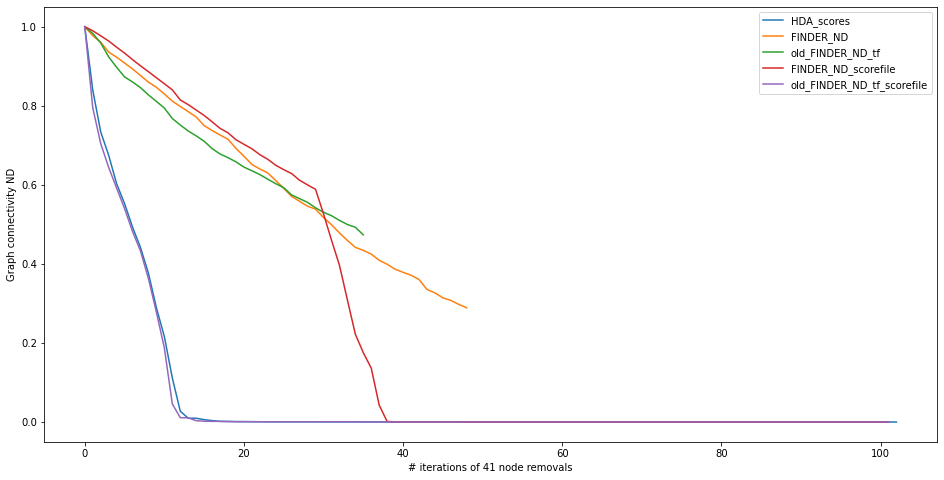

In [56]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))

#plt.plot(CN_scores, label='CN')
for key in exp_dict.keys():
    plt.plot(exp_dict[key], label=key)
    
#plt.plot(CI_scores, label='CI')
plt.legend()
plt.xlabel("# iterations of {} node removals".format(k))
plt.ylabel("Graph connectivity {}".format(experiment_type))